# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

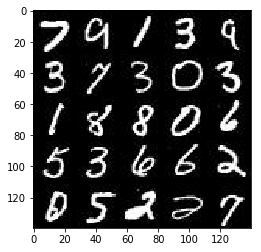

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

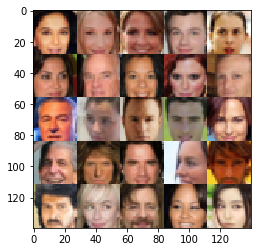

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,None,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

In [15]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
     
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input Layer is 28x28xChannels
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7x7x512 Now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x256 Now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 28x28x128 Now
        
        # Output Layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 Now
        
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


# Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    
    num, width, height, depth = data_shape
    inputs_real, inputs_z, learn_rate = model_inputs(width, height, depth, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = tf.random_uniform([10, z_dim], -1, 1)
    losses = []
    count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                
                batch_images_norm = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                
                if count % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    train_loss_g = g_loss.eval({inputs_real: batch_images_norm,
                                               inputs_z: batch_z,
                                               learn_rate: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if count % 100 == 0:
                    show_generator_output(sess, 10, sample_z, depth, data_image_mode)
                    
    return losses 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 19.2746
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 14.6518
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 3.8688
Epoch 1/2... Discriminator Loss: 6.7136... Generator Loss: 10.1477
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 2.3589
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 3.3216
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.7010
Epoch 1/2... Discriminator Loss: 0.9808... Generator Loss: 2.2408
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 1.9974
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.4757


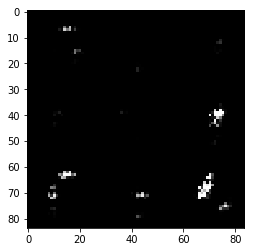

Epoch 1/2... Discriminator Loss: 1.6398... Generator Loss: 1.7133
Epoch 1/2... Discriminator Loss: 3.6107... Generator Loss: 4.2945
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 1.8255
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.4777
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 1.7100
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.8750
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 1.2150
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 2.0359... Generator Loss: 0.2392


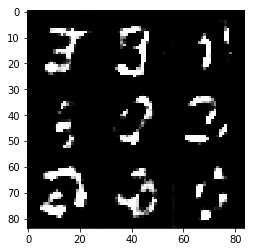

Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 0.4396
Epoch 1/2... Discriminator Loss: 4.2862... Generator Loss: 5.7067
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.7539
Epoch 1/2... Discriminator Loss: 0.7798... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 1.6659... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 2.0190
Epoch 1/2... Discriminator Loss: 0.7596... Generator Loss: 3.7181
Epoch 1/2... Discriminator Loss: 1.6887... Generator Loss: 0.4256


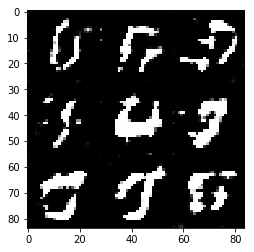

Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 2.5659
Epoch 1/2... Discriminator Loss: 1.6755... Generator Loss: 2.4759
Epoch 1/2... Discriminator Loss: 1.7626... Generator Loss: 0.3308
Epoch 1/2... Discriminator Loss: 0.6679... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.5134
Epoch 1/2... Discriminator Loss: 2.0585... Generator Loss: 4.1876
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.8395... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.5852


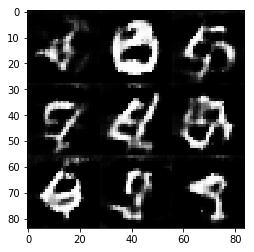

Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 1.6057... Generator Loss: 2.0472
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 1.7273
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 1.4143... Generator Loss: 1.7280
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 2.6833
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 1.3604


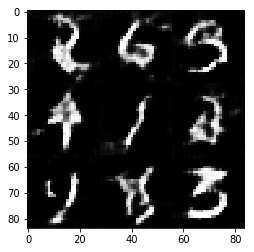

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.5370
Epoch 1/2... Discriminator Loss: 1.6681... Generator Loss: 0.3560
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.5727
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 1.1842
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.4829
Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.7895


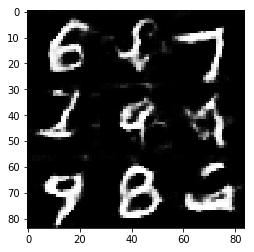

Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.4628
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 1.1947


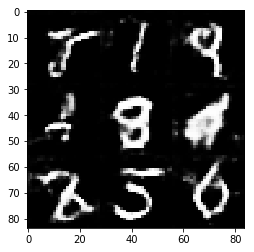

Epoch 1/2... Discriminator Loss: 1.9007... Generator Loss: 0.2927
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.5084... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 1.6890
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 1.3542
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.9193


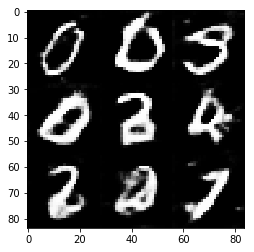

Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 1.9073
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 1.7712
Epoch 1/2... Discriminator Loss: 1.6678... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.4676
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 1.2907
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.9183... Generator Loss: 0.2989


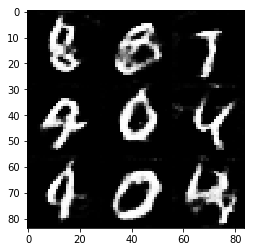

Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 1.6039
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 1.1473
Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 0.9029
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.2065
Epoch 2/2... Discriminator Loss: 1.5287... Generator Loss: 1.6295
Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 1.6988
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.7227... Generator Loss: 0.3461


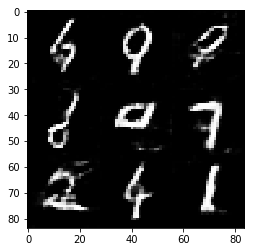

Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5756
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 1.4879... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 0.5533
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.8970


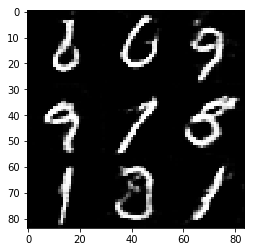

Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 2.0643
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.4046... Generator Loss: 0.5414
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 1.5331
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.6575
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 1.6329... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6321


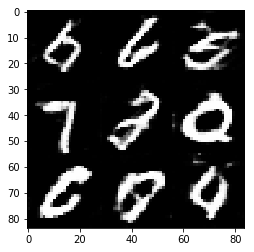

Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.8605
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.5238... Generator Loss: 0.4831
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 1.6238
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 1.3382


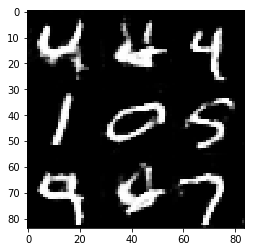

Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 1.3458
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.8095
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 1.5418
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 1.5027
Epoch 2/2... Discriminator Loss: 1.1617... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 0.9194


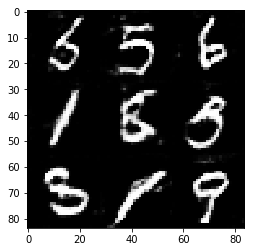

Epoch 2/2... Discriminator Loss: 1.4965... Generator Loss: 0.4658
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.5086... Generator Loss: 0.4564
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 1.9623
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 1.1832
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.5590


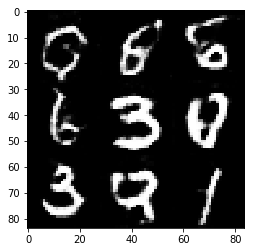

Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 2.1641
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 1.5518
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 1.3001
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.5257
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.6361
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.5054... Generator Loss: 2.4994


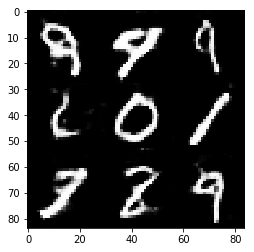

Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.4360
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 1.2034
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 1.3777
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.0963
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 1.4845


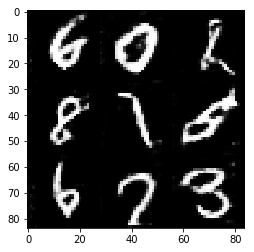

Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.6372
Epoch 2/2... Discriminator Loss: 1.7596... Generator Loss: 0.3854
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 1.5615... Generator Loss: 0.4597
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 1.3824


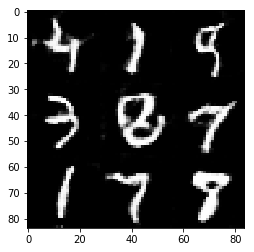

Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.7418
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 2.5317
Epoch 2/2... Discriminator Loss: 1.6663... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 1.7021


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 10.9943
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.7981
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 2.6333... Generator Loss: 7.9930
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 3.2727
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 3.4058
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.7492


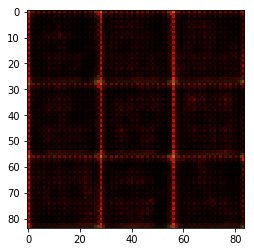

Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 5.4830
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 4.9813
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 7.3668
Epoch 1/1... Discriminator Loss: 3.7168... Generator Loss: 7.6879
Epoch 1/1... Discriminator Loss: 3.0928... Generator Loss: 0.0868
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.6885


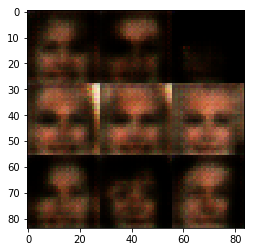

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.6476... Generator Loss: 3.2122
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.3352
Epoch 1/1... Discriminator Loss: 1.9453... Generator Loss: 0.2451
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.7943
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.5374


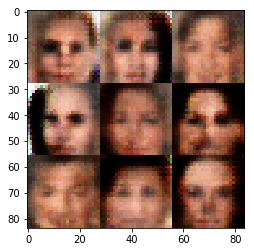

Epoch 1/1... Discriminator Loss: 2.0139... Generator Loss: 0.2299
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.2708
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 2.3723
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.8274
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1375


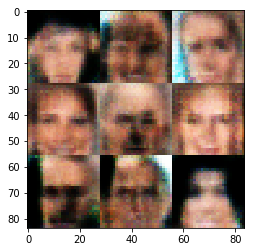

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.3152


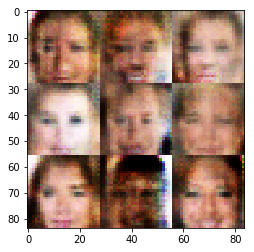

Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 1.1098


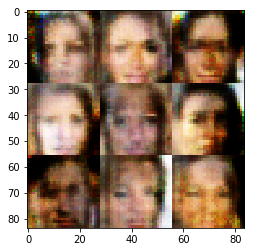

Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.4996
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 1.9707
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 1.4423


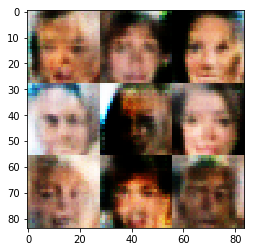

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 1.3795
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 1.9194
Epoch 1/1... Discriminator Loss: 1.7534... Generator Loss: 1.9684


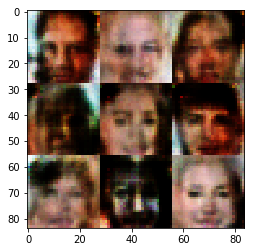

Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 2.0037... Generator Loss: 0.2463
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 1.7094
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0411


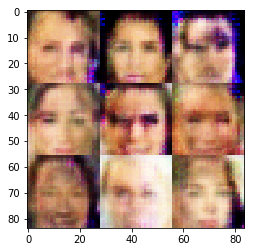

Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.7591
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 1.8571
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.0048


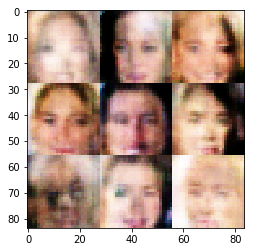

Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.6977... Generator Loss: 0.3392
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.3010
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 1.6991
Epoch 1/1... Discriminator Loss: 1.9733... Generator Loss: 1.8824


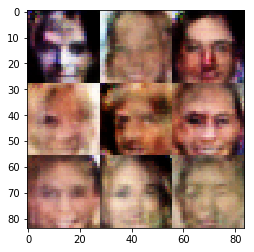

Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 2.1292
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6803


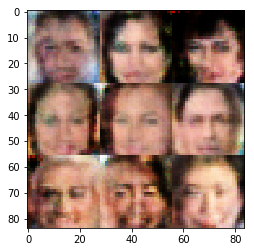

Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7083


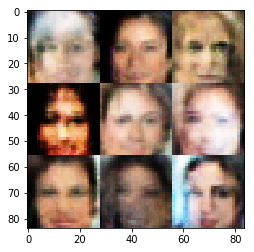

Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5058


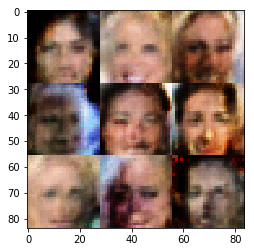

Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.6728
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.6330


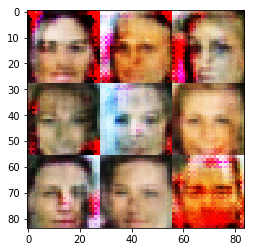

Epoch 1/1... Discriminator Loss: 2.0544... Generator Loss: 3.1794
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.7171... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 1.3926


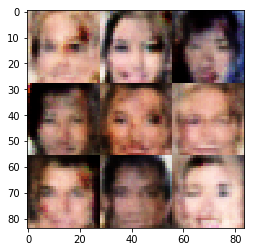

Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 1.6821
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0346


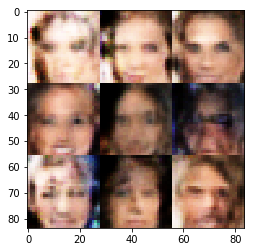

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8497


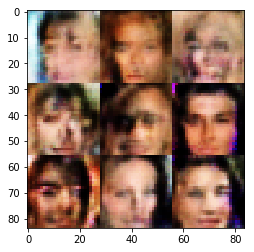

Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 2.5611... Generator Loss: 2.4837
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6011


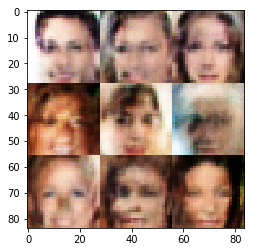

Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 1.8632
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.5492


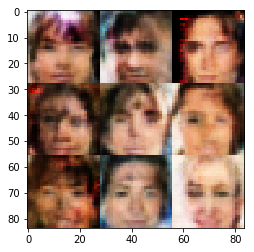

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7795


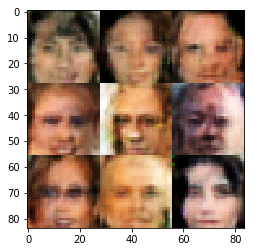

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.3030


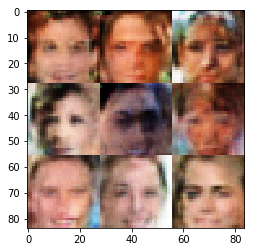

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.9760


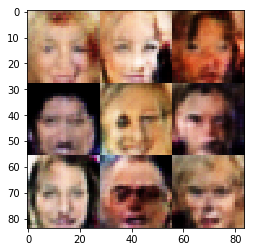

Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.1373
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6903


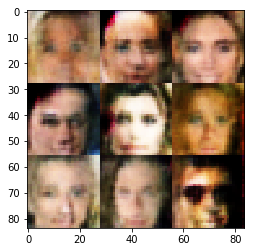

Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 3.0651... Generator Loss: 3.6101
Epoch 1/1... Discriminator Loss: 2.4118... Generator Loss: 2.2533
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.9255
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.1705


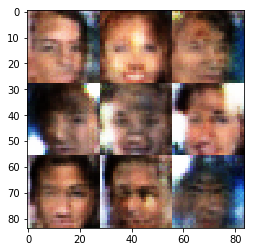

Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.6558
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.1674


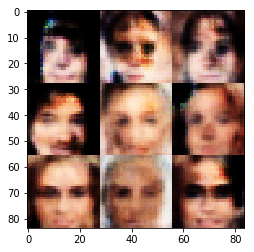

Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.8424... Generator Loss: 1.8885
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.3524


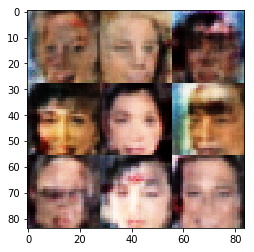

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.0151


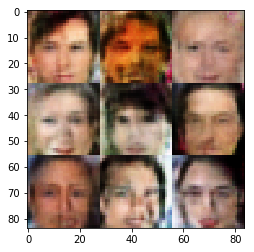

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5658


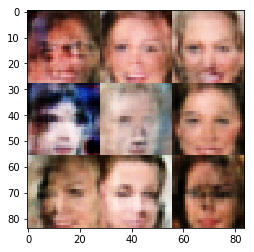

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 1.3564
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 1.6738


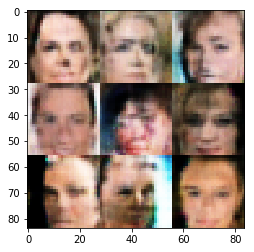

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.6249


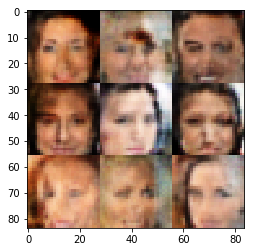

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 1.2403


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.